# PyTorch之数据加载和处理
## 下载安装包
- scikit-image: 用于图像的IO和变换
```
conda install scikit-image
```
- pandas: 用于更容易地进行csv解析
```
conda install pandas
```

## 引用包

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd # 用于更容易地进行csv解析
from skimage import io, transform # 用于图像的IO和变换
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# 忽略警告
import warnings
warnings.filterwarnings('ignore')

plt.ion() # matplotlib开启交互模式

## 下载数据
使用命令行下载数据集到'data/faces'的目录中, 使用的命令如下:
```
wget -P /file/PyTorch_Study/data/ "https://download.pytorch.org/tutorial/faces.zip"
```
然后使用如下命令进行解压:
```
unzip -n faces.zip -d  /file/PyTorch_Study/data/
```
最后使用如下命令删除faces.zip文件:
```rm -rf faces.zip
```

## 数据集注释
数据集是按如下规则打包成csv文件的:
```
image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x, ... ,part_67_x,part_67_y0805personali01.jpg,27,83,27,98, ... 84,1341084239450_e76e00b7e7.jpg,70,236,71,257, ... ,128,312
```

csv存储格式如下:

![figure.1](https://gitee.com/zyp521/upload_image/raw/master/WloV5Z.png)

## 读取数据
将csv中的标注点数据读入(N,2)，其中N是特征点的数量，2是标注点的横纵坐标，读取数据代码如下:

In [2]:
landmarks_frame = pd.read_csv('/file/PyTorch_Study/data/faces/face_landmarks.csv')

n = 65 # 图片个数
img_name = landmarks_frame.iloc[n, 0] # csv文件第一行为图片的名称，一行后面的数据为特征点
landmarks = landmarks_frame.iloc[n,1:].values # 将每一行的后面内容形成一个矩阵 as_matrix()不在使用了，改成了values
landmarks = landmarks.astype('float').reshape(-1,2) # 转换为坐标格式 （横，纵）

### 数据结果

In [3]:
print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


## 编写函数
写一个简单的函数来将图片展示，并且将特征点也展示出来:

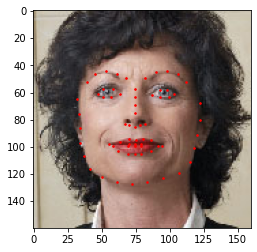

In [4]:
def show_landmarks(image, landmarks):
    """
        展示带有特征点的图片
    """
    plt.imshow(image)
    plt.scatter(landmarks[:,0], landmarks[:,1], s=10, marker='.', c='r') # 绘制特征点散点图
    plt.pause(0.001) 

plt.figure()
show_landmarks(io.imread(os.path.join('data/faces', img_name)), landmarks)
plt.show()

## 数据集类
torch.utils.data.Dataset是表示数据集的抽象类，因此自定义数据集应继承Dataset并覆盖一下方法:
- __init__ 初始化数据集配置的函数
- __len__ 实现len(dataset)返还数据集的尺寸
- __getitem__ 用来获取一些索引数据
### 建立数据集类
为面部数据创建一个数据集类，将在__init__中读取csv的文件内容，在__getitem__中读取图片，这么做是为了节省内存空间，而不需要一次性将所有的数据读入，只有在需要用到图片的时候才去读取它。  

这里我们将数据样本按照这样一个字典{'image':image, 'landmarks':landmarks}来进行组织。这里给数据集类添加上一个可选参数transform参数以方便对样本进行预处理，具体在后面会介绍transform的使用。  

数据集类构建代码:

In [7]:
class FaceLandmarksDataset(Dataset): # 继承torch.utils.data.Dataset
    """
        面部标记数据集
    """
    # fixme: 初始化函数
    def __init__(self, csv_file, root_dir, transform = None):
        """
        :params csv_file String: csv文件路径
        :params root_dir String: 图片存储目录路径
        :params transform Callable, Optional: 一个样本上的可用的可选变换
        """
        self.landmarks_frame = pd.read_csv(csv_file) # 读取csv文件
        self.root_dir = root_dir
        self.transform = transform
    
    # fixme: 返回数据集长度
    def __len__(self):
        return len(self.landmarks_frame)
    
    # fixme: 逐元素返回函数
    def __getitem__(self, index):
        """
        :params index Int: 要求返回的下标
        """
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[index,0]) # 生成带有图片名称的路径
        image = io.imread(img_name) # 读取图片
        landmarks = self.landmarks_frame.iloc[index, 1:] # 读取图片对应的所有特征点信息
        landmarks = np.array([landmarks]) # 转换为numpy数组
        landmarks = landmarks.astype('float').reshape(-1,2) # 转换为float对应的坐标形式
        res = {'image':image, 'landmarks':landmarks} # 形成字典形式
        
        # 如果transform非空则进行数据变换
        if self.transform:
            res = self.transform(res)
        
        return res

## 数据可视化
实例化这个类并遍历数据样本，下面将打印出前四个例子的尺寸并展示标注的特征点。

展示第 0 张图片，图片的尺寸为: (324, 215, 3) 图片的标志点个数为 68


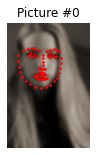

展示第 1 张图片，图片的尺寸为: (500, 333, 3) 图片的标志点个数为 68


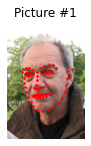

展示第 2 张图片，图片的尺寸为: (250, 258, 3) 图片的标志点个数为 68


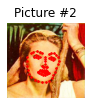

展示第 3 张图片，图片的尺寸为: (434, 290, 3) 图片的标志点个数为 68


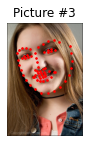

In [12]:
csv_file = '/file/PyTorch_Study/data/faces/face_landmarks.csv'
root_dir = '/file/PyTorch_Study/data/faces/'
face_dataset = FaceLandmarksDataset(csv_file=csv_file, root_dir=root_dir)

fig = plt.figure()

for i in range(len(face_dataset)): # 这里的len，就用到了__len__函数
    res = face_dataset[i] # 这里face_dataset[i]，就用到了__getitem__函数
    print('展示第',i,'张图片，图片的尺寸为:',res['image'].shape,'图片的标志点个数为',res['landmarks'].shape[0])
    
    # 图片可视化
    ax = plt.subplot(1, 4, i+1)
    plt.tight_layout() # 用于自动调整subplot绘制图像之间的padding
    ax.set_title('Picture #{}'.format(i))
    ax.axis('off') # 关闭横轴名字
    plt.imshow(res['image'])
    plt.scatter(res['landmarks'][:,0], res['landmarks'][:,1], s=10, marker='.', c='r') # 绘制特征点散点图
    plt.pause(0.001)
    
    if i == 3:
        break

## 数据变换
通过上面的例子，我们发现图片之间并不是相同的尺寸，绝大多数神经网络都是假定图片的尺寸相同。因此这里需要做一些针对图像的预处理。  
下面将实现三个转换:
- (1)Rescale: 图像尺度缩放
- (2)RandomCrop: 对图像进行随机裁剪 (这是一种数据增强的操作)
- (3)ToTensor: 将numpy格式的图片转换为torch格式的图片

这里会将它们写成一个可调用的类的形式(不需要实例化，使用__call__方法实现)，而不是一个简单的函数，这样就不需要每次调用的时候都要传一遍参数了。

In [13]:
class Rescale(object):
    """将样本中的图像重新缩放到给定大小。
    .Args:
        output_size（tuple或int）：所需的输出大小。 如果是元组，则输出为
        与output_size匹配。 如果是int，则匹配较小的图像边缘到output_size保持纵横比相同。
    """
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(image, (new_h, new_w))
        landmarks = landmarks * [new_w / w, new_h / h]
        return {'image': img, 'landmarks': landmarks}

In [14]:
class RandomCrop(object):
    """随机裁剪样本中的图像
    .Args:
        output_size（tuple或int）：所需的输出大小。 如果是int，方形裁剪是。    
    """
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        image = image[top: top + new_h,left: left + new_w]
        landmarks = landmarks - [left, top]
        return {'image': image, 'landmarks': landmarks}

In [15]:
class ToTensor(object):
    """将样本中的ndarrays转换为Tensors."""
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        # 交换颜色轴因为
        # numpy包的图片是: H * W * C
        # torch包的图片是: C * H * W
        image = image.transpose((2, 0, 1)) # 交换颜色轴
        return {'image': torch.from_numpy(image),'landmarks': torch.from_numpy(landmarks)}

## 组合变换
下面是将这些变换组合到一起，下面是一个例子:  
我们想要把图像的短边调整为256，然后随机裁剪为224大小的正方形，即将ReScale和RandomCrop组合起来形成一个变换。  

可以通过调用torchvision.transforms.Compose来实现这个操作.

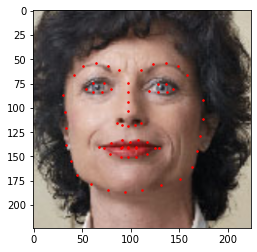

In [22]:
scale = Rescale(256) # 大小调整为256
crop = RandomCrop(224) # 随机裁剪成224
composed = transforms.Compose([scale, crop]) # 组合到一起

# 在样本上应用上述的组合变换
fig = plt.figure()
sample = face_dataset[65] # 取第65张图片
transform_sample = composed(sample)
plt.imshow(transform_sample['image'])
plt.scatter(transform_sample['landmarks'][:,0], transform_sample['landmarks'][:,1], s=10, marker='.', c='r') # 绘制特征点散点图
plt.show()

## torchvision
torchvision 包提供了 常用的数据集类(datasets)和转换(transforms)。你可能不需要自己构造这些类。 torchvision 中还有一个更常用的数据集类 ImageFolder 。 它假定了数据集是以如下方式构造的: 
```
root/ants/xxx.png
root/ants/xxy.jpeg
root/ants/xxz.png
...
root/bees/123.jpg
root/bees/nsdf3.png
root/bees/asd932_.png
```
其中’ants’,bees’等是分类标签。在 PIL.Image 中你也可以使用类似的转换(transforms)。  
例如RandomHorizontalFlip, Scale 。利用这些你可以按如下的方式创建一个数据加载器(dataloader)

In [26]:
import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
    transforms.RandomSizedCrop(224), # transforms.RandomResizedCrop(224) 将给定图像随机裁剪为不同的大小和宽高比，然后缩放所裁剪得到的图像为制定的大小；（即先随机采集，然后对裁剪得到的图像缩放为同一大小） 默认scale=(0.08, 1.0)
    transforms.RandomHorizontalFlip(), # transforms.RandomHorizontalFlip() 以给定的概率随机水平旋转给定的PIL的图像，默认为0.5；
    transforms.ToTensor(), # numpy转化为tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]) # 归一化处理,这里的mean和std并不是指最终归一化的结果，而是作为一个运算变量
])

hymenoptera_dataset = datasets.ImageFolder(root='hymenoptera_data/train',transform=data_transform)

dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,batch_size=4, shuffle=True,num_workers=4)